<h1> CREAZIONE MODELLO SARIMA BELGIO

In [1]:
import pandas as pd
df = pd.read_csv('../../csv/nazioni/serie_storica_be.csv')
df.head()

,TIME,GEO,Value
0,2015-01-05,Belgium,2461
1,2015-01-12,Belgium,2525
2,2015-01-19,Belgium,2526
3,2015-01-26,Belgium,2510
4,2015-02-02,Belgium,2644


In [2]:
df['TIME'] = pd.to_datetime(df['TIME'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    300 non-null    datetime64[ns]
 1   GEO     300 non-null    object        
 2   Value   300 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 7.2+ KB


In [4]:
df=df.set_index('TIME')
df.head()

,GEO,Value
TIME,,
2015-01-05,Belgium,2461
2015-01-12,Belgium,2525
2015-01-19,Belgium,2526
2015-01-26,Belgium,2510
2015-02-02,Belgium,2644


<h3>Creazione serie storica dei decessi totali

In [5]:
df = df.groupby(pd.Grouper(freq='M')).sum()
df.head()

,Value
TIME,
2015-01-31,10022
2015-02-28,11037
2015-03-31,12130
2015-04-30,8620
2015-05-31,7994


In [6]:
ts = df.Value
ts.head()

TIME
2015-01-31    10022
2015-02-28    11037
2015-03-31    12130
2015-04-30     8620
2015-05-31     7994
Freq: M, Name: Value, dtype: int64

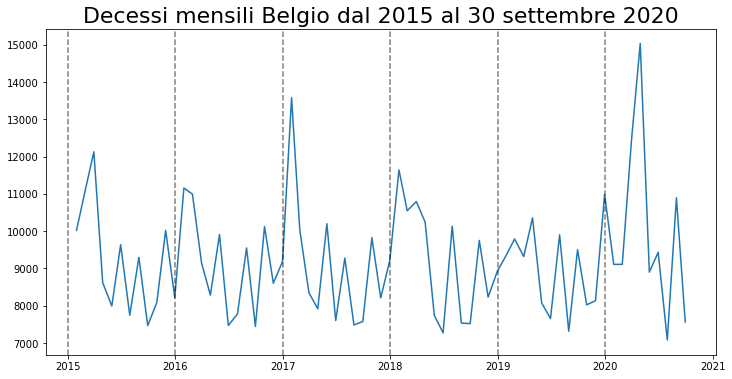

In [8]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,9,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili Belgio dal 2015 al 30 settembre 2020', size=22)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Decomposizione

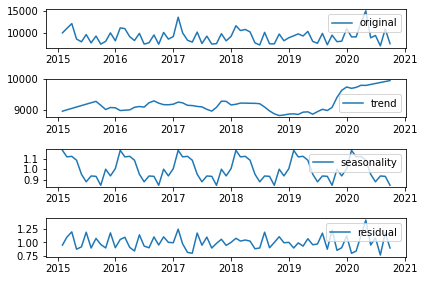

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h3>Test di stazionarietà

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

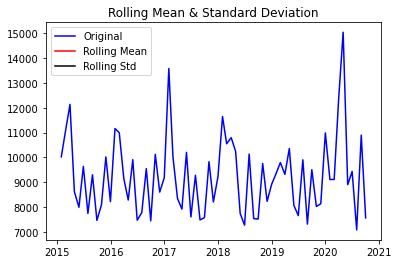

Results of Dickey-Fuller Test:
Test Statistic                -7.218437e+00
p-value                        2.142531e-10
#Lags Used                     0.000000e+00
Number of Observations Used    6.800000e+01
Critical Value (1%)           -3.530399e+00
Critical Value (5%)           -2.905087e+00
Critical Value (10%)          -2.590001e+00
dtype: float64
X is stationary


True

In [11]:
test_stationarity(ts)

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2015 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [12]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,8,30)


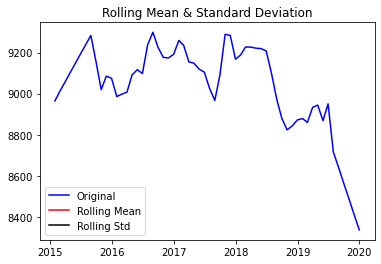

Results of Dickey-Fuller Test:
Test Statistic                 -0.087868
p-value                         0.950634
#Lags Used                      1.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64
X is not stationary


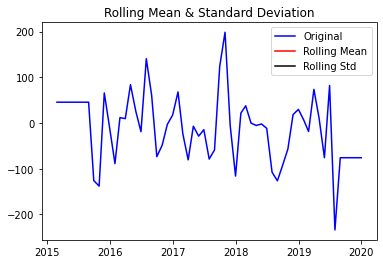

Results of Dickey-Fuller Test:
Test Statistic                -5.727998e+00
p-value                        6.701396e-07
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64
X is stationary
1


In [13]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h3>Grafici di Autocorrelazione e Autocorrelazione Parziale

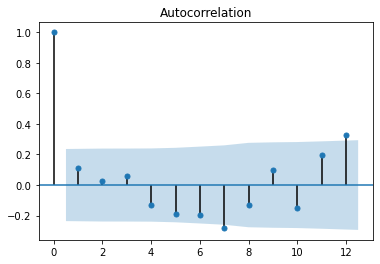

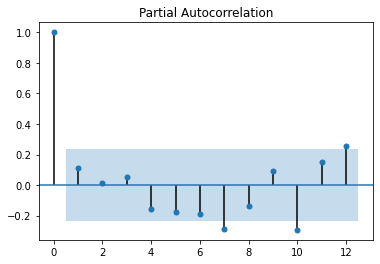

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(6,0,6))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   58
Model:               SARIMAX(6, 0, 6)   Log Likelihood                -491.424
Date:                Sat, 12 Dec 2020   AIC                           1008.848
Time:                        17:29:12   BIC                           1035.633
Sample:                    01-31-2015   HQIC                          1019.281
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6286      2.627      0.239      0.811      -4.520       5.777
ar.L2          0.9166      4.232      0.217      0.829      -7.378       9.212
ar.L3          0.0136      1.758      0.008      0.9

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>Verifica della stazionarietà dei residui del modello ottenuto

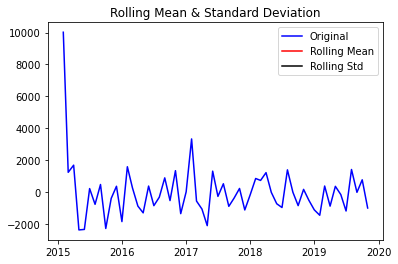

Results of Dickey-Fuller Test:
Test Statistic                -1.113352e+01
p-value                        3.237682e-20
#Lags Used                     0.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64
X is stationary


True

In [16]:
residuals = model_fit.resid
test_stationarity(residuals)

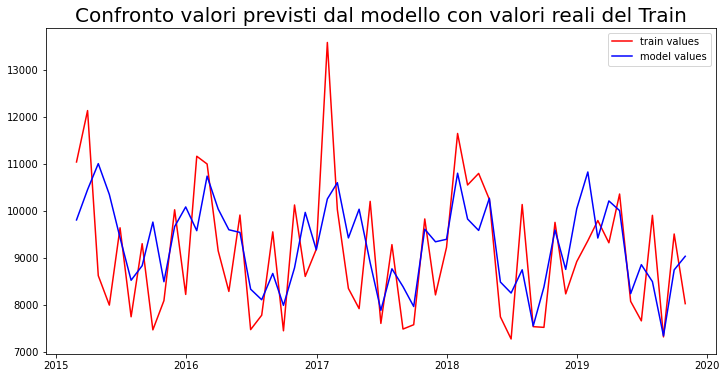

In [17]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()


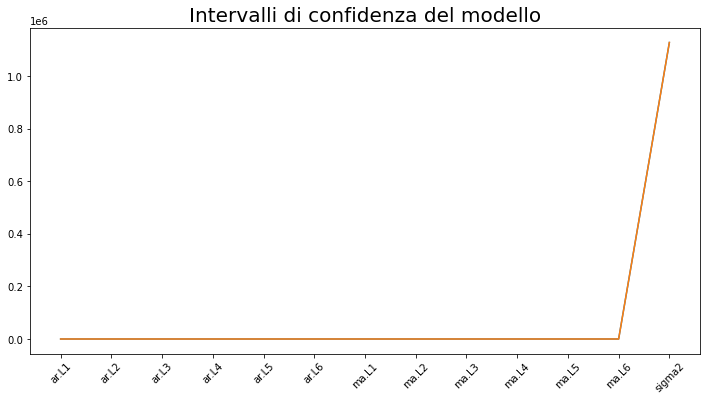

In [18]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h3>Predizione del modello sul Test

In [19]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-30 00:00:00


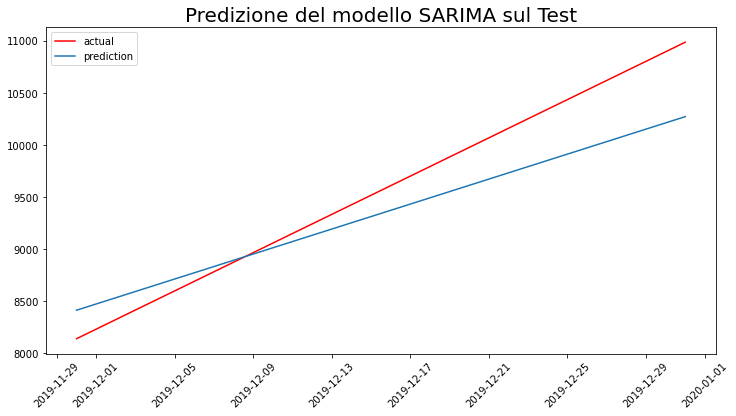

2019-11-30     8410.559359
2019-12-31    10269.998445
Freq: M, Name: predicted_mean, dtype: float64


In [20]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]


#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)


plt.figure(figsize=(12,6))
plt.title('Predizione del modello SARIMA sul Test', size=20)
plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

<h3>Calcolo dell'indice RMSE

In [21]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.19007140230638345


<h2>Predizione del modello compreso l'anno 2020

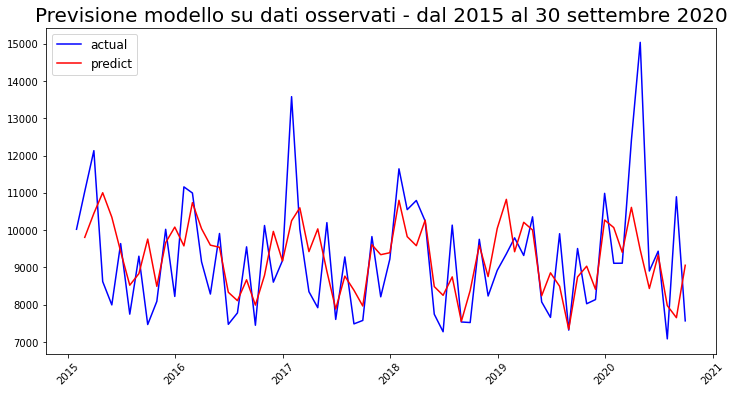

In [22]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 settembre 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

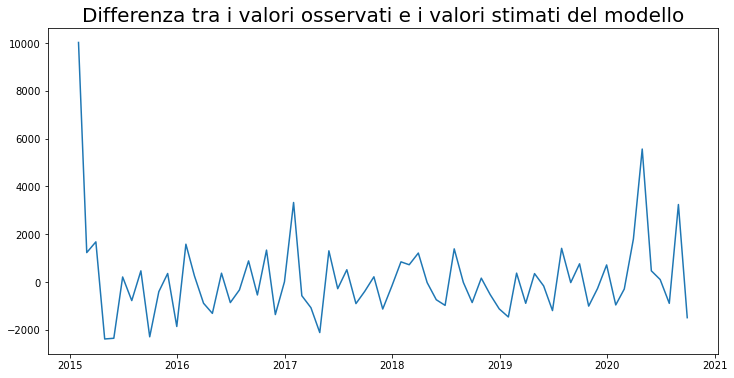

In [23]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [24]:
diff_predictions_tot['24-02-2020':].sum()

8504.497327006127

In [25]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_be.csv')

<h2>Intervalli di confidenza della previsione totale

In [26]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower Value'])

2015-01-31        0.000000
2015-02-28     9804.763371
2015-03-31    10449.021945
2015-04-30    11002.009153
2015-05-31    10346.193574
                  ...     
2020-05-31     8433.836191
2020-06-30     9329.893604
2020-07-31     7974.559757
2020-08-31     7651.347133
2020-09-30     9057.057526
Freq: M, Name: predicted_mean, Length: 69, dtype: float64
             lower Value   upper Value
2015-01-31 -16676.971243  16676.971243
2015-02-28   6351.297084  13258.229658
2015-03-31   7364.187242  13533.856648
2015-04-30   8121.440948  13882.577357
2015-05-31   7473.652760  13218.734388
...                  ...           ...
2020-05-31   6310.930692  10556.741691
2020-06-30   7206.240858  11453.546350
2020-07-31   5850.396207  10098.723307
2020-08-31   5522.738652   9779.955614
2020-09-30   6928.447065  11185.667988

[69 rows x 2 columns]
2015-01-31    16676.971243
2015-02-28     3453.466287
2015-03-31     3084.834703
2015-04-30     2880.568205
2015-05-31     2872.540814
                  .

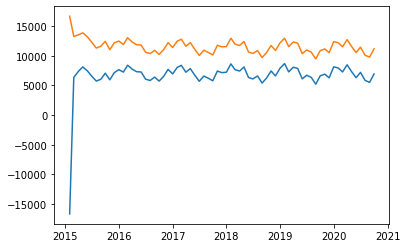

In [27]:
plt.plot(in_c)
plt.show()

In [29]:
upper = in_c['upper Value']
lower = in_c['lower Value']

In [30]:
lower.to_csv('../../csv/lower/predictions_SARIMA_be_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_be_upper.csv')